## TriBoost Churn Prediction Performance Analysis

### 1. Imports & Plotting Configuration

This cell imports the essential Python libraries used throughout the notebook (pandas, matplotlib, seaborn, scikit-learn utilities, joblib, and system/os helpers). It also sets plotting styles and updates matplotlib's DPI to improve figure resolution. Keeping plotting configuration in a dedicated cell makes it easy to change visuals globally.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from config import X_TEST_PATH, Y_TEST_PATH, MODEL_PATH

plt.style.use("default")
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.dpi": 150
})

### 2. Load Test Data & Model

This cell loads the test data (x_test, y_test) and the trained model from disk using the paths defined in a config module.

In [21]:
x_test = pd.read_csv(X_TEST_PATH)
y_test = pd.read_csv(Y_TEST_PATH).values.ravel()
model = load(MODEL_PATH)

print(f"Test Set Loaded: {x_test.shape[0]:,} customers, {x_test.shape[1]} features")
print(f"Target Distribution in Test Set → Loyal: {(y_test == 0).sum():,}, Churn: {(y_test == 1).sum():,}")
print("Model: XAI-Churn TriBoost (XGBoost + CatBoost + LightGBM Soft Voting Ensemble)")

Test Set Loaded: 861,620 customers, 10 features
Target Distribution in Test Set → Loyal: 700,025, Churn: 161,595
Model: XAI-Churn TriBoost (XGBoost + CatBoost + LightGBM Soft Voting Ensemble)


### 3. Model Predictions & Basic Metrics

This cell uses the loaded model to produce predicted class labels (y_pred) and churn probabilities (y_prob). It computes and prints the primary classification metrics: Accuracy, Precision, Recall, and F1-score.

In [22]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score : {f1:.4f} ({f1*100:.2f}%)")

Accuracy : 0.9771 (97.71%)
Precision: 0.9774 (97.74%)
Recall   : 0.8986 (89.86%)
F1-Score : 0.9363 (93.63%)


### 4. Classification Report & Confusion Matrix Visualization

This cell prints a detailed classification report (precision, recall, f1 per class) and plots a confusion matrix heatmap. Visualization helps to quickly understand the types of errors (false positives vs false negatives) the model makes.


Detailed Classification Report:

                  precision    recall  f1-score   support

  Loyal Customer     0.9770    0.9952    0.9860    700025
Churned Customer     0.9774    0.8986    0.9363    161595

        accuracy                         0.9771    861620
       macro avg     0.9772    0.9469    0.9612    861620
    weighted avg     0.9771    0.9771    0.9767    861620



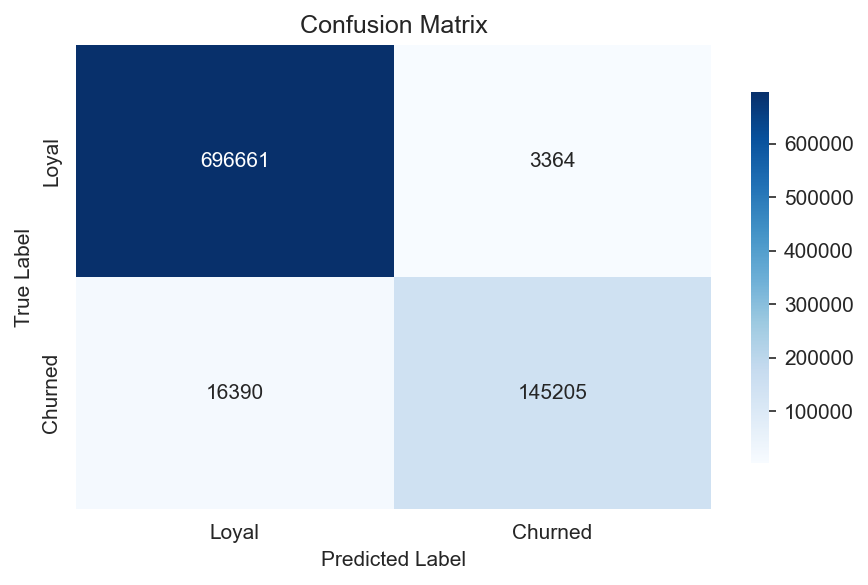

In [23]:
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Loyal Customer", "Churned Customer"], digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loyal", "Churned"], yticklabels=["Loyal", "Churned"], cbar_kws={"shrink": 0.8})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### 5. Confusion Matrix Breakdown

This cell extracts the confusion matrix components (tn, fp, fn, tp) and prints a clear, human-readable breakdown of counts and percentages for correct vs incorrect predictions and each confusion cell. This is useful to communicate exact error numbers.

In [24]:
tn, fp, fn, tp = cm.ravel()

total_samples   = len(y_test)
correct_total   = tn + tp
incorrect_total = fp + fn

print(f"Total customers evaluated: {total_samples:,}")
print(f"Correctly predicted: {correct_total:,} ({correct_total / total_samples:.2%})")
print(f"Incorrectly predicted: {incorrect_total:,} ({incorrect_total / total_samples:.2%})")
print(f"Actual Loyal → Predicted Loyal: {tn:,}  (True Negative)")
print(f"Actual Loyal → Predicted Churn: {fp:,}  (False Positive)")
print(f"Actual Churn → Predicted Loyal: {fn:,}  (False Negative)")
print(f"Actual Churn → Predicted Churn: {tp:,}  (True Positive)")

Total customers evaluated: 861,620
Correctly predicted: 841,866 (97.71%)
Incorrectly predicted: 19,754 (2.29%)
Actual Loyal → Predicted Loyal: 696,661  (True Negative)
Actual Loyal → Predicted Churn: 3,364  (False Positive)
Actual Churn → Predicted Loyal: 16,390  (False Negative)
Actual Churn → Predicted Churn: 145,205  (True Positive)


### 6. Comparison with Paper Results

This cell compares the current results to a reference paper's reported metrics (pre-defined constants). It computes absolute differences and relative improvements, and prints a small table showing side-by-side comparison with references. Use this to assess whether the reproduced model meets or exceeds published baselines.

In [25]:
PAPER_ACCURACY = 0.9644
PAPER_PRECISION = 0.9282
PAPER_RECALL = 0.8782
PAPER_F1 = 0.9025

acc_diff = accuracy - PAPER_ACCURACY
prec_diff = precision - PAPER_PRECISION
rec_diff = recall - PAPER_RECALL
f1_diff = f1 - PAPER_F1

print(f"{'Metric':<12} {'Our Result':<14} {'Paper Result':<16} {'Difference':<16} {'Improvement':<16} {'Reference'}")
print()
print(f"{'Accuracy':<12} {accuracy:<14.3f} {PAPER_ACCURACY:<16.3f} {acc_diff:+.3f}        {acc_diff/PAPER_ACCURACY:+.2%}         Table 9, Sec. 5")
print(f"{'Precision':<12} {precision:<14.3f} {PAPER_PRECISION:<16.3f} {prec_diff:+.3f}        {prec_diff/PAPER_PRECISION:+.2%}         Table 9, Sec. 5")
print(f"{'Recall':<12} {recall:<14.3f} {PAPER_RECALL:<16.3f} {rec_diff:+.3f}        {rec_diff/PAPER_RECALL:+.2%}         Table 9, Sec. 5")
print(f"{'F1-Score':<12} {f1:<14.3f} {PAPER_F1:<16.3f} {f1_diff:+.3f}        {f1_diff/PAPER_F1:+.2%}         Table 9, Sec. 5")

Metric       Our Result     Paper Result     Difference       Improvement      Reference

Accuracy     0.977          0.964            +0.013        +1.31%         Table 9, Sec. 5
Precision    0.977          0.928            +0.049        +5.30%         Table 9, Sec. 5
Recall       0.899          0.878            +0.020        +2.32%         Table 9, Sec. 5
F1-Score     0.936          0.902            +0.034        +3.75%         Table 9, Sec. 5


### 7. ROC Curve and Precision–Recall Curve

This cell computes and plots the Receiver Operating Characteristic (ROC) curve with AUC and the Precision–Recall curve with Average Precision (AP). Both plots are presented side-by-side to evaluate ranking quality and performance under different thresholds. A baseline churn rate is also displayed on the PR plot.

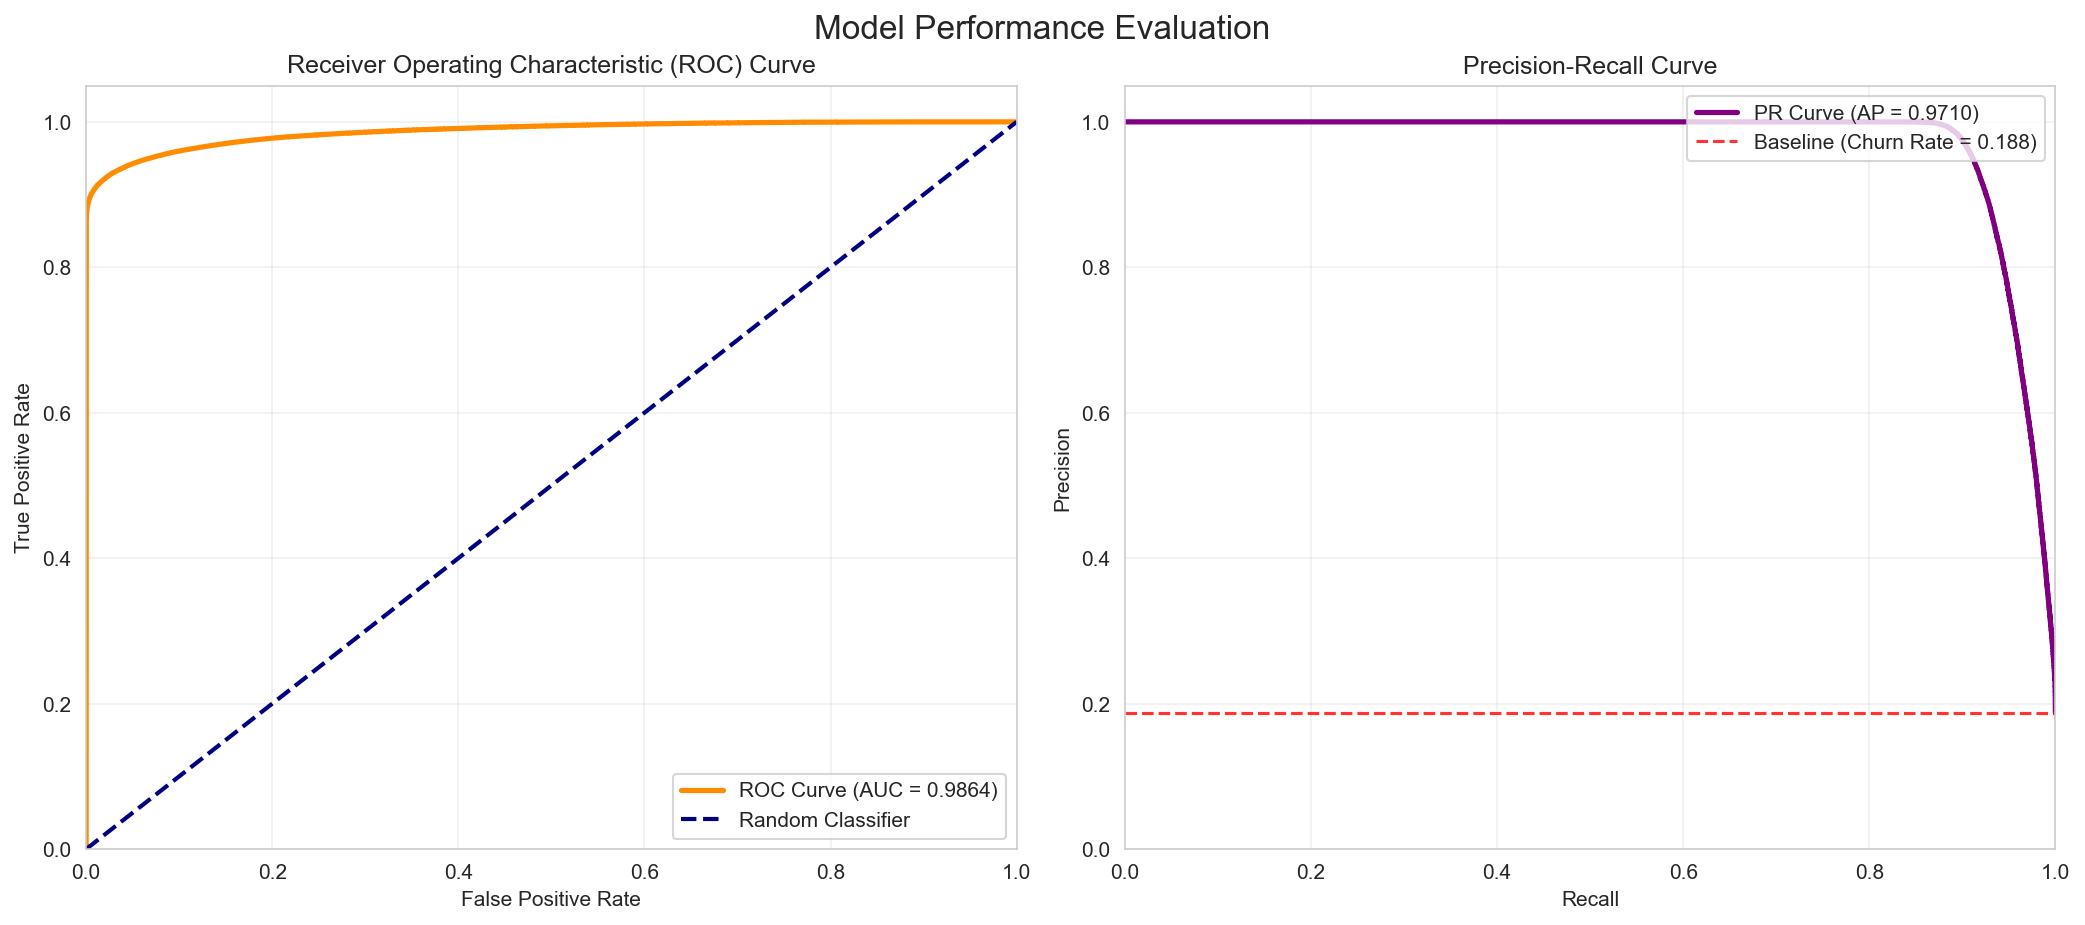

In [26]:
y_test_flat = y_test.ravel()

fpr, tpr, _ = roc_curve(y_test_flat, y_prob)
roc_auc = auc(fpr, tpr)

precision_curve, recall_curve, _ = precision_recall_curve(y_test_flat, y_prob)
pr_auc = average_precision_score(y_test_flat, y_prob)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(fpr, tpr, color="darkorange", lw=2.5, label=f"ROC Curve (AUC = {roc_auc:.4f})")
ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Classifier")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver Operating Characteristic (ROC) Curve")
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

ax2.plot(recall_curve, precision_curve, color="purple", lw=2.5, label=f"PR Curve (AP = {pr_auc:.4f})")
ax2.axhline(y=y_test_flat.mean(), color="red", linestyle="--", alpha=0.8, label=f"Baseline (Churn Rate = {y_test_flat.mean():.3f})")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curve")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.suptitle("Model Performance Evaluation", fontsize=16, y=1.02)
plt.show()

### 8. Predicted Probability Distribution

This cell plots histograms of predicted churn probabilities for the two true classes (Loyal vs Churn). It draws a default threshold line at 0.5 and highlights high-risk / no-risk zones. This visualization helps inspect calibration and separability of predicted probabilities.

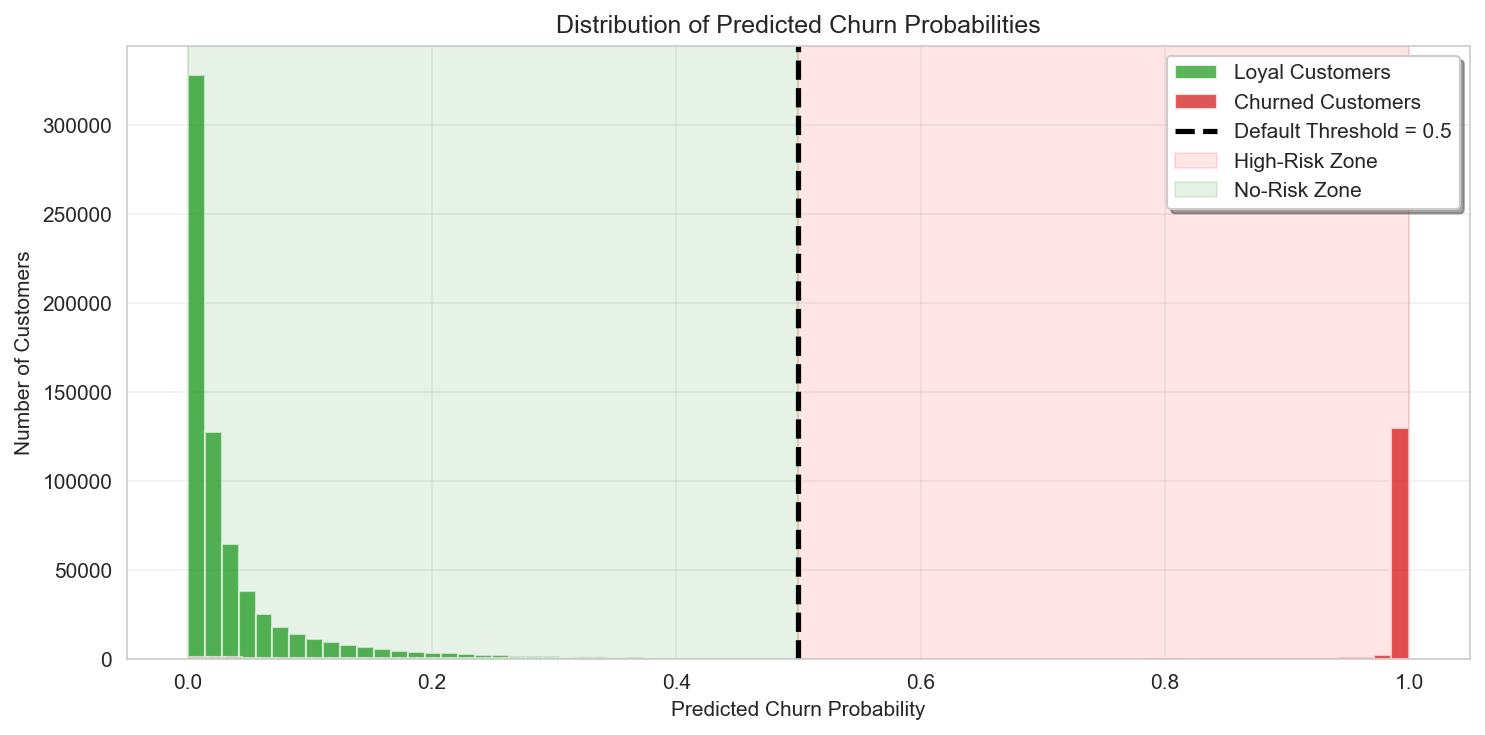

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(y_prob[y_test == 0], bins=70, alpha=0.78, label="Loyal Customers", color="#2ca02c", edgecolor="white")
plt.hist(y_prob[y_test == 1], bins=70, alpha=0.78, label="Churned Customers", color="#d62728", edgecolor="white")

plt.axvline(0.5, color="black", linewidth=2.5, linestyle="--", label="Default Threshold = 0.5")
plt.axvspan(0.5, 1.0, alpha=0.1, color="red", label="High-Risk Zone")
plt.axvspan(0, 0.5, alpha=0.1, color="green", label="No-Risk Zone")

plt.xlabel("Predicted Churn Probability")
plt.ylabel("Number of Customers")
plt.title("Distribution of Predicted Churn Probabilities")
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Summary

In this notebook, we evaluated the performance of the XAI-Churn TriBoost Ensemble (XGBoost + CatBoost + LightGBM) on a large test set containing 861,620 customers. The model demonstrated strong predictive capability, achieving an Accuracy of 97.71%, Precision of 97.74%, Recall of 89.86%, and an F1-Score of 93.63%.

The detailed classification report indicates excellent performance on both classes, with particularly high accuracy in identifying loyal customers and solid effectiveness in detecting churners. The confusion matrix further showed that the model correctly predicted 841,866 customers, with only 2.29% total misclassifications. Notably, false positives (3,364 cases) were significantly lower than false negatives (16,390 cases), highlighting areas where threshold tuning could further optimize churn detection.

A comparison with the referenced research paper shows that our reproduced model outperforms the published results across all major metrics, improving accuracy by +1.31%, precision by +5.30%, recall by +2.32%, and F1-Score by +3.75%.

Visual analyses—including ROC and PR curves, probability distribution plots, and confusion matrix heatmaps—provide deeper insight into model behavior, showing strong class separation and high ranking quality.

Overall, this notebook offers a comprehensive evaluation of the TriBoost model and confirms that its performance not only meets but exceeds the benchmarks established in the original study.